In [1]:
import xarray
import os
import pandas as pd
import Preprocessing_test

extractor = Preprocessing_test.FileExtractor()

df_dwd_hornsea = extractor.combine_files("data", "dwd_icon_eu_hornsea")
df_dwd_pes = extractor.combine_files("data", "dwd_icon_eu_pes10")
df_dwd_demand = extractor.combine_files("data", "dwd_icon_eu_demand")

ncep_gfs_hornsea = extractor.combine_files("data", "ncep_gfs_hornsea")
ncep_gfs_pes = extractor.combine_files("data", "ncep_gfs_pes10")
ncep_gfs_demand = extractor.combine_files("data", "ncep_gfs_demand")

import numpy as np
import dask.dataframe as dd
import math

preprocesser = Preprocessing_test.Preprocessing()

df_dwd_hornsea = preprocesser.preprocess_geo_data(df_dwd_hornsea)
ncep_gfs_hornsea = preprocesser.preprocess_geo_data(ncep_gfs_hornsea)
df_dwd_pes = preprocesser.preprocess_geo_data(df_dwd_pes)
ncep_gfs_pes = preprocesser.preprocess_geo_data(ncep_gfs_pes)
df_dwd_demand = preprocesser.preprocess_geo_data(df_dwd_demand)
ncep_gfs_demand = preprocesser.preprocess_geo_data(ncep_gfs_demand)

hornsea = preprocesser.merge_weather_stations_data(df_dwd_hornsea, ncep_gfs_hornsea)
demand = preprocesser.merge_weather_stations_data(df_dwd_demand, ncep_gfs_demand)
pes = preprocesser.merge_weather_stations_data(df_dwd_pes, ncep_gfs_pes)

df_energy = extractor.combine_files("data", "Energy_data", ".csv")
df_energy = preprocesser.preprocess_energy_data(df_energy)

merged_hornsea = preprocesser.merge_geo_energy_outage_data(hornsea, df_energy)
merged_pes = preprocesser.merge_geo_energy_outage_data(pes, df_energy)
merged_demand = preprocesser.merge_geo_energy_outage_data(demand, df_energy)

merged_hornsea = preprocesser.add_difference_features(merged_hornsea)
merged_pes = preprocesser.add_difference_features(merged_pes)
merged_demand = preprocesser.add_difference_features(merged_demand)

In [2]:
# import model_utils

# merged_hornsea = pd.read_parquet("./data/preprocessed_hornsea_with_energy.parquet")
# merged_pes = pd.read_parquet("./data/preprocessed_pes_with_energy.parquet")

In [3]:
# import importlib
# import Preprocessing_final
# importlib.reload(Preprocessing_final)



# feature_engineerer_wind = Preprocessing_final.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
# feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

# feature_engineerer_solar = Preprocessing_final.FeatureEngineerer(label = "Wind_MWh_credit")
# feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

# merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
# feature_engineerer_solar_baseline = Preprocessing_final.FeatureEngineerer(label = 'Solar_MWh_credit')
# feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

# merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
# feature_engineerer_wind_baseline = Preprocessing_final.FeatureEngineerer(label = 'Wind_MWh_credit')
# feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

In [4]:
feature_engineerer_wind = Preprocessing_test.FeatureEngineerer(merged_hornsea, label = 'Wind_MWh_credit')
feature_engineerer_solar = Preprocessing_test.FeatureEngineerer(merged_pes, label = 'Solar_MWh_credit')

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing_test.FeatureEngineerer(merged_pes_simple, label = 'Solar_MWh_credit')

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing_test.FeatureEngineerer(merged_hornsea_simple, label = 'Wind_MWh_credit')

### __Wind Energy Forecast__

__baseline__

In [41]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_wind\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_wind\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import warnings

# Unterdrücken von FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_quantils(x, y, quantiles):

    first_month = x.index[0].month  # Den Monat des ersten Datums nehmen
    first_month_data = x[x.index.month == first_month]  # Nur die Daten für den ersten Monat filtern
    filter = len(first_month_data.index)
    
    # 2. Filtere die entsprechenden Zeilen aus `y`

    plt.figure(figsize=(10,6))
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    ax1 = sns.lineplot( x=first_month_data.index, y=y["true"][:filter])

    for quantile in quantiles:
        sns.lineplot(
                    x=first_month_data.index,
                    y=y[str(quantile)][:filter],
                    color='gray',
                    alpha=(1-abs(1-quantile)),
                    label=f'q{quantile}')

    #plt.xlim(x.index.min())
    plt.xlabel('Date/Time')
    plt.ylabel('Generation [MWh]')
    plt.tight_layout()

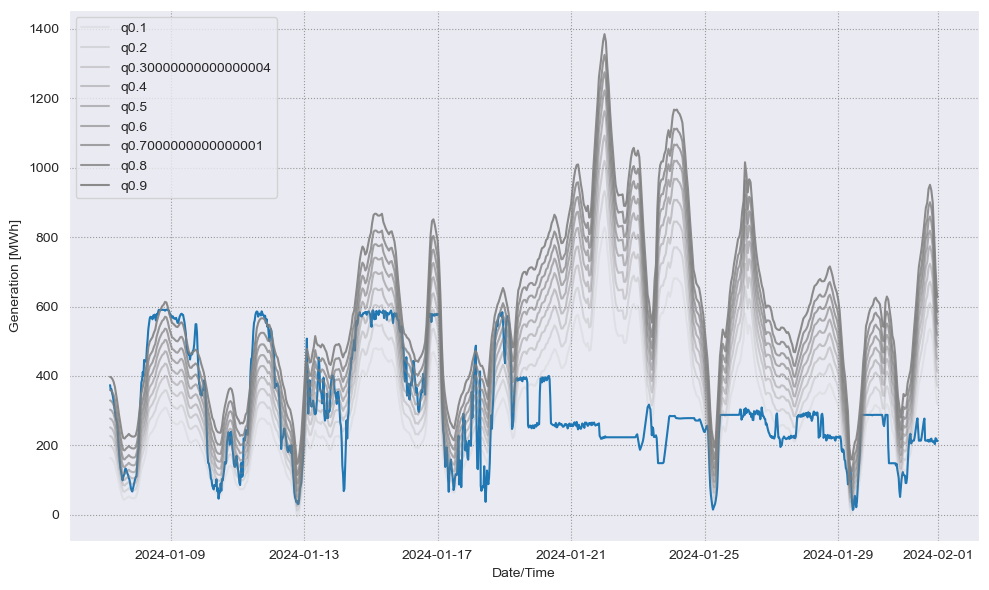

In [54]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [63]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }




xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:98.07658	Val-quantile:90.10249
[1]	Train-quantile:97.02260	Val-quantile:89.29769
[2]	Train-quantile:95.98153	Val-quantile:88.50522
[3]	Train-quantile:94.95212	Val-quantile:87.72368
[4]	Train-quantile:93.93412	Val-quantile:86.94793
[5]	Train-quantile:92.92846	Val-quantile:86.18083
[6]	Train-quantile:91.93397	Val-quantile:85.42358
[7]	Train-quantile:90.95059	Val-quantile:84.67727
[8]	Train-quantile:89.97841	Val-quantile:83.93875
[9]	Train-quantile:89.01670	Val-quantile:83.21478
[10]	Train-quantile:88.06519	Val-quantile:82.50114
[11]	Train-quantile:87.12314	Val-quantile:81.79392
[12]	Train-quantile:86.19380	Val-quantile:81.10191
[13]	Train-quantile:85.27520	Val-quantile:80.41913
[14]	Train-quantile:84.36750	Val-quantile:79.74571
[15]	Train-quantile:83.46853	Val-quantile:79.07761
[16]	Train-quantile:82.58366	Val-quantile:78.42487
[17]	Train-quantile:81.70713	Val-quantile:77.77016
[18]	Train-quantile:80.84339	Val-quantile:77.13007
[19]	Train-quantile:79.98766	Val-quantile

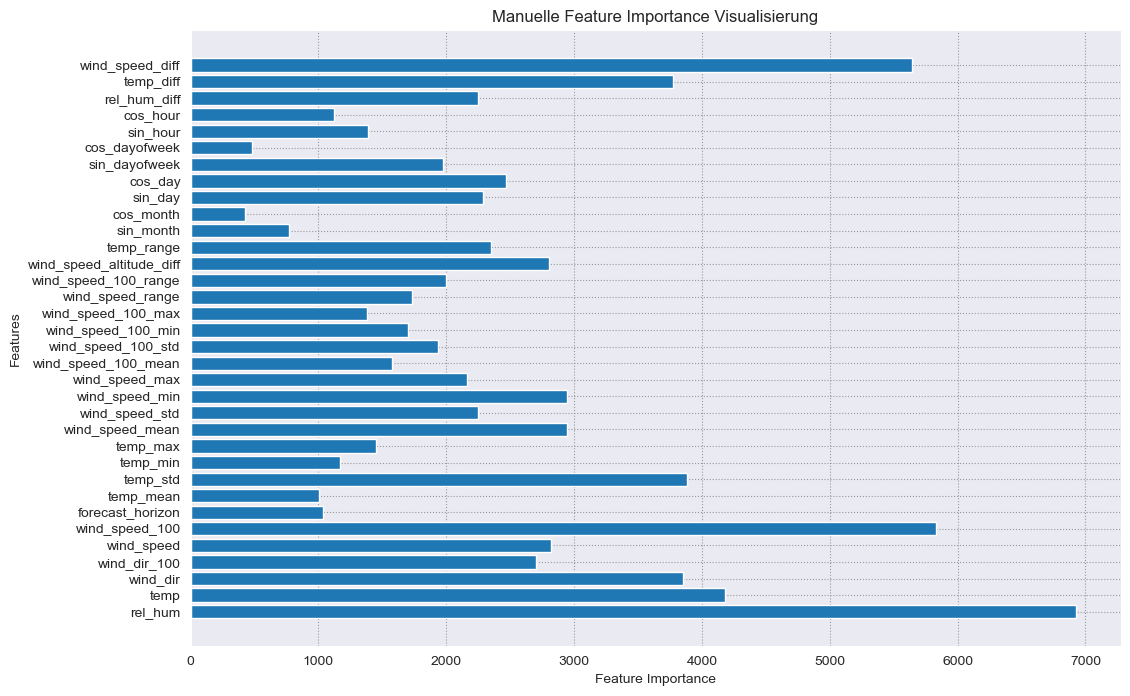

In [64]:
# Feature-Wichtigkeiten abrufen
import matplotlib.pylab as plt

booster = xgboost_model_wind.booster
importance_dict = booster.get_score(importance_type='weight')
# In ein Pandas DataFrame umwandeln für einfache Verarbeitung
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df["feature_name"] = merged_hornsea.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Nach Wichtigkeit sortieren
# importance_df = importance_df.sort_values(by='Index', ascending=False)

# Plotten
plt.figure(figsize=(12, 8))  # Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.title('Manuelle Feature Importance Visualisierung')
plt.show()

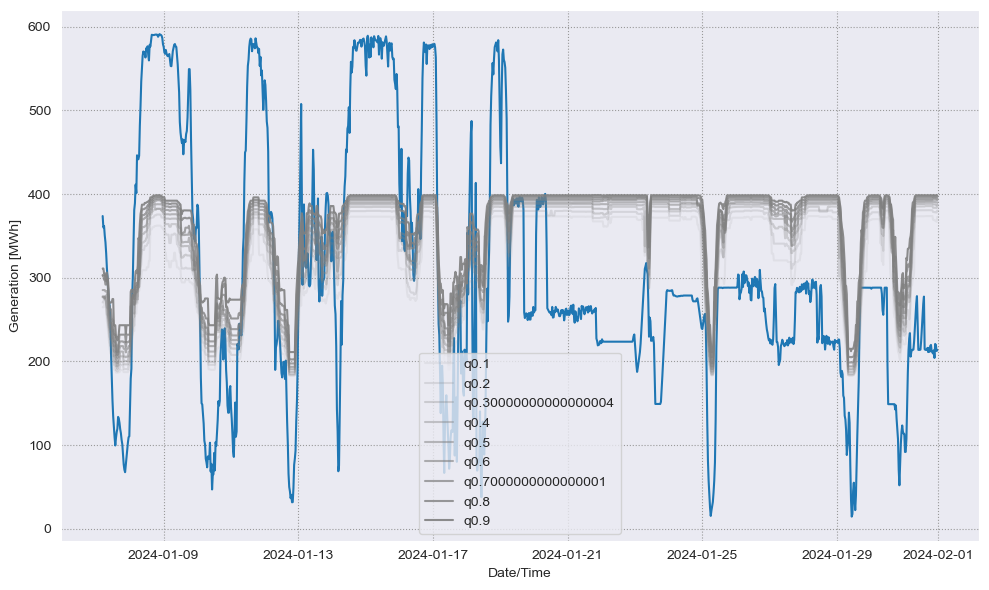

In [65]:
xgboost_model_wind.plot_quantils(x=feature_engineerer_wind.y_test, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

### __Solar Energy Forecast__

__baseline modell__

In [58]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_solar\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_solar\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_solar\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_solar\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_solar\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_solar\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_solar\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_solar\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_solar\qr_model_q

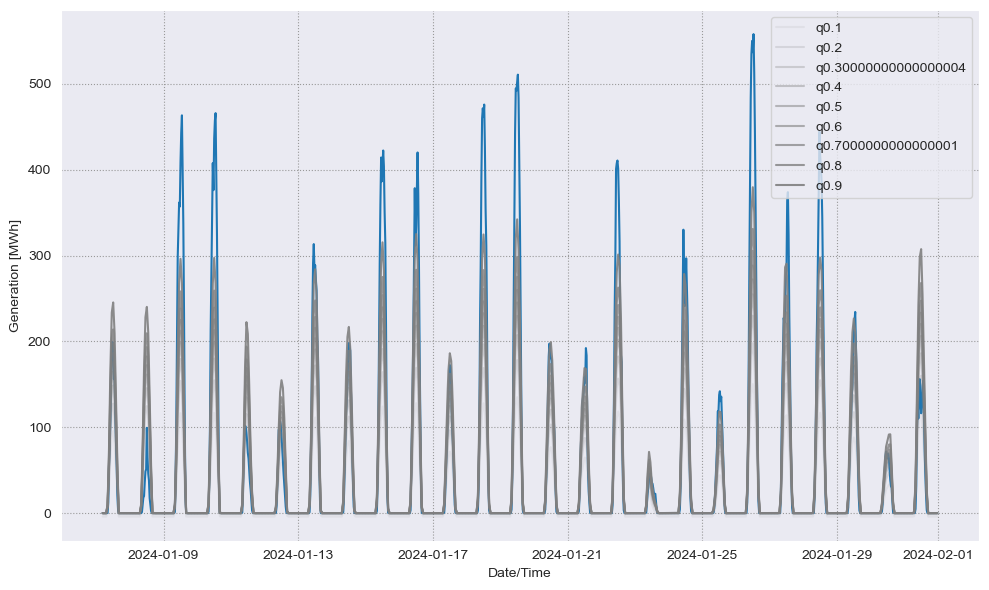

In [59]:
qr_model_solar.plot_quantils(x=feature_engineerer_solar_baseline.y_test, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [60]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.13515	Val-quantile:92.39949
[1]	Train-quantile:42.29184	Val-quantile:88.13729
[2]	Train-quantile:40.54912	Val-quantile:84.14312
[3]	Train-quantile:38.89848	Val-quantile:80.30528
[4]	Train-quantile:37.31716	Val-quantile:76.64144
[5]	Train-quantile:35.80335	Val-quantile:73.11867
[6]	Train-quantile:34.35909	Val-quantile:69.76359
[7]	Train-quantile:32.98317	Val-quantile:66.56863
[8]	Train-quantile:31.66048	Val-quantile:63.54328
[9]	Train-quantile:30.40100	Val-quantile:60.65396
[10]	Train-quantile:29.19980	Val-quantile:57.91469
[11]	Train-quantile:28.06596	Val-quantile:55.29548
[12]	Train-quantile:26.97471	Val-quantile:52.83934
[13]	Train-quantile:25.94129	Val-quantile:50.50737
[14]	Train-quantile:24.95708	Val-quantile:48.31265
[15]	Train-quantile:24.01307	Val-quantile:46.22179
[16]	Train-quantile:23.12180	Val-quantile:44.20001
[17]	Train-quantile:22.27242	Val-quantile:42.36014
[18]	Train-quantile:21.46098	Val-quantile:40.56213
[19]	Train-quantile:20.68992	Val-quantile

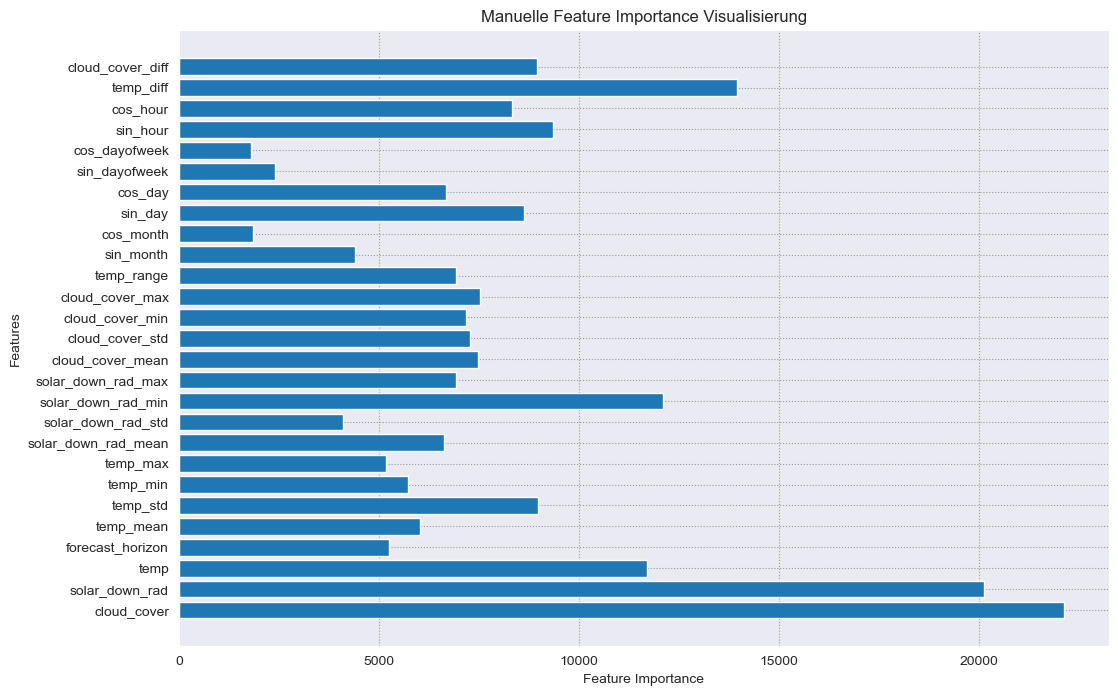

In [61]:
# Feature-Wichtigkeiten abrufen
import matplotlib.pylab as plt

booster = xgboost_model_solar.booster
importance_dict = booster.get_score(importance_type='weight')

# In ein Pandas DataFrame umwandeln für einfache Verarbeitung
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df["feature_name"] = merged_pes.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Nach Wichtigkeit sortieren
# importance_df = importance_df.sort_values(by='Index', ascending=False)

# Plotten
plt.figure(figsize=(12, 8))  # Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.title('Manuelle Feature Importance Visualisierung')
plt.show()

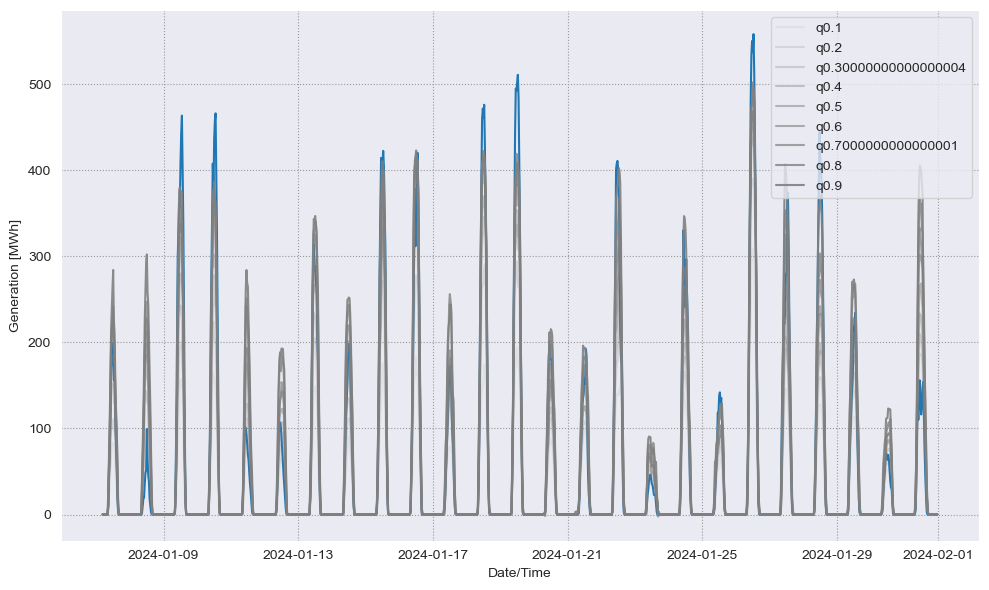

In [62]:
xgboost_model_solar.plot_quantils(x=feature_engineerer_solar.y_test, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

### __Lightgbm implementation__

In [16]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
importlib.reload(model_utils)

quantiles = [x for x in np.arange(0.1, 1.0, 0.1)]
qr_solar_lightgbm = {}
qr_solar_lightgbm["true"] = feature_engineerer_solar.y_test.values
#out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)

for quantile in quantiles:
    print(f"Training for quantile: {quantile}")
    qr_lightgbm = lgb.LGBMRegressor(objective='quantile', alpha=quantile, n_estimators=1000, force_col_wise=True)
    qr_lightgbm.fit(
        feature_engineerer_solar.X_train, 
        feature_engineerer_solar.y_train,
        eval_set=[(feature_engineerer_solar.X_train, feature_engineerer_solar.y_train), 
                  (feature_engineerer_solar.X_val, feature_engineerer_solar.y_val)],
        eval_names=['train', 'valid'],
        eval_metric='quantile',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
    )
    qr_solar_lightgbm[str(quantile)] = qr_lightgbm.predict(feature_engineerer_solar.X_test)

qr_solar_lightgbm_df = pd.DataFrame(qr_solar_lightgbm)
model_utils.pinball_score(qr_solar_lightgbm_df, quantiles=quantiles)

Training for quantile: 0.1
[LightGBM] [Info] Total Bins 5040
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 27
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 5.14861	valid's quantile: 5.4345
[100]	train's quantile: 4.66668	valid's quantile: 5.10018
[150]	train's quantile: 4.66474	valid's quantile: 5.09484
[200]	train's quantile: 4.66473	valid's quantile: 5.09477
[250]	train's quantile: 4.66473	valid's quantile: 5.09477
[300]	train's quantile: 4.66473	valid's quantile: 5.09477
[350]	train's quantile: 4.66473	valid's quantile: 5.09477
[400]	train's quantile: 4.66473	valid's quantile: 5.09477
Early stopping, best iteration is:
[379]	train's quantile: 4.66473	valid's quantile: 5.09477
Training for quantile: 0.2
[LightGBM] [Info] Total Bins 5040
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 27
Training until validation scores don't improve for 50 rounds
[50]	train's qu

7.354711369628847

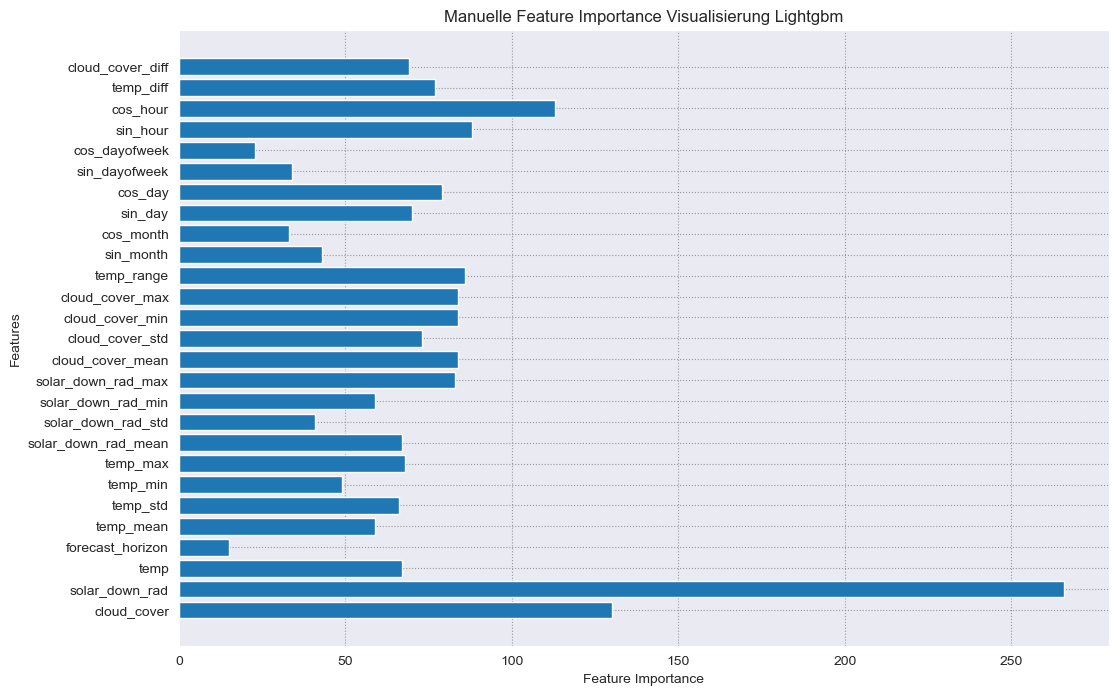

In [17]:
importance_df = pd.DataFrame({
    'Feature': qr_lightgbm.feature_name_,
    'Importance': qr_lightgbm.feature_importances_
})

# Nach Wichtigkeit sortieren
#importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df["feature_name"] = merged_pes.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Plotten der Feature Importance
plt.figure(figsize=(12, 8))  # Plot-Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Manuelle Feature Importance Visualisierung Lightgbm')
plt.grid(True)
plt.show()

In [18]:
quantiles = [x for x in np.arange(0.1, 1.0, 0.1)]
qr_wind_lightgbm = {}
qr_wind_lightgbm["true"] = feature_engineerer_wind.y_test.values
#out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr_lightgbm_wind = lgb.LGBMRegressor(objective='quantile', alpha=quantile, n_estimators=1000, force_col_wise=True, learning_rate=0.3)
    qr_lightgbm_wind.fit(
        feature_engineerer_wind.X_train, 
        feature_engineerer_wind.y_train,
        eval_set=[(feature_engineerer_wind.X_train, feature_engineerer_wind.y_train), 
                  (feature_engineerer_wind.X_val, feature_engineerer_wind.y_val)],
        eval_names=['train', 'valid'],
        eval_metric='quantile',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(30)],
        )
    qr_wind_lightgbm[str(quantile)] = qr_lightgbm_wind.predict(feature_engineerer_wind.X_test)

qr_wind_lightgbm_df = pd.DataFrame(qr_wind_lightgbm)
model_utils.pinball_score(qr_wind_lightgbm_df, quantiles=quantiles)

[LightGBM] [Info] Total Bins 6825
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 34
[LightGBM] [Info] Start training from score 9.724700
Training until validation scores don't improve for 50 rounds
[30]	train's quantile: 10.1098	valid's quantile: 15.6138
[60]	train's quantile: 10.101	valid's quantile: 15.617
Early stopping, best iteration is:
[19]	train's quantile: 10.4499	valid's quantile: 15.5435
[LightGBM] [Info] Total Bins 6825
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 34
[LightGBM] [Info] Start training from score 45.381004
Training until validation scores don't improve for 50 rounds
[30]	train's quantile: 14.1913	valid's quantile: 21.3766
[60]	train's quantile: 13.8605	valid's quantile: 21.4865
Early stopping, best iteration is:
[21]	train's quantile: 14.5109	valid's quantile: 21.264
[LightGBM] [Info] Total Bins 6825
[LightGBM] [Info] Number of data points in the train set: 48168, number of

134.59274464659245

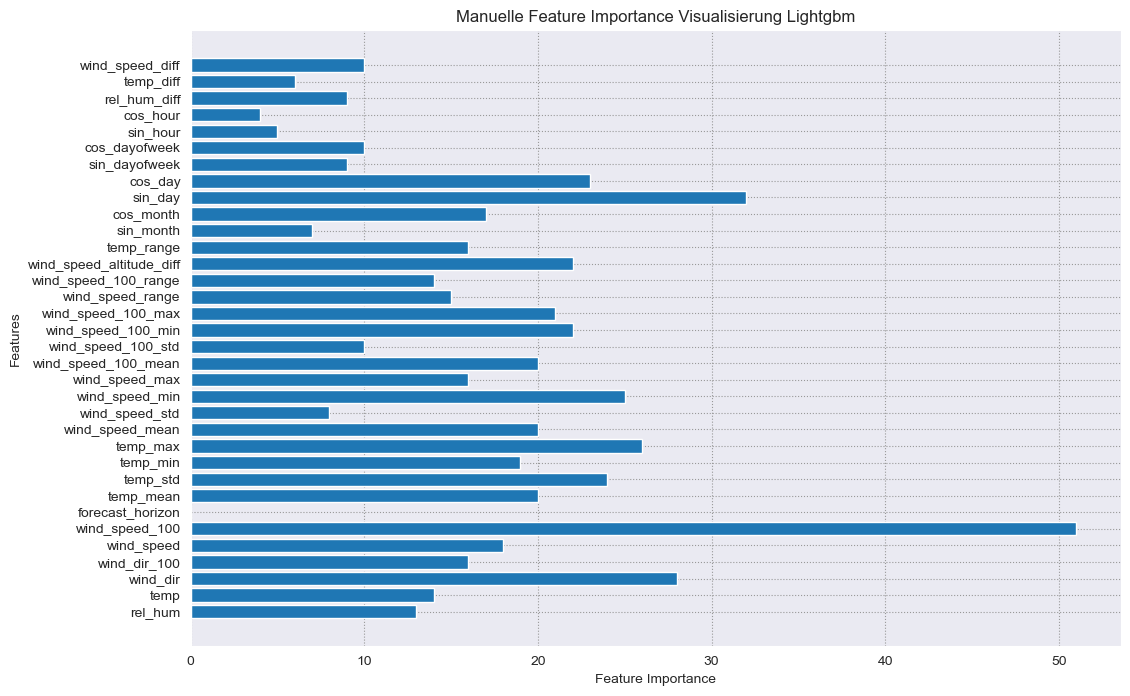

In [19]:
importance_df = pd.DataFrame({
    'Feature': qr_lightgbm_wind.feature_name_,
    'Importance': qr_lightgbm_wind.feature_importances_
})

# Nach Wichtigkeit sortieren
#importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df["feature_name"] = merged_hornsea.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Plotten der Feature Importance
plt.figure(figsize=(12, 8))  # Plot-Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Manuelle Feature Importance Visualisierung Lightgbm')
plt.grid(True)
plt.show()

In [67]:
import torch
import torch.nn as nn

class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(
                torch.max(
                   (q-1) * errors, 
                   q * errors
            ).unsqueeze(1))
        loss = torch.mean(
            torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [85]:
from functools import partial
from itertools import chain

class q_model(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=34,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)

In [86]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [90]:
class Learner:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            print(f"{e}. epoche startet: ")
            # shuffle_idx = np.arange(x.shape[0])
            # np.random.shuffle(shuffle_idx)
            # x = x[shuffle_idx]
            # y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(x[idx : min(idx + batch_size, x.shape[0]),:]).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(y[idx : min(idx + batch_size, y.shape[0])]).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = self.loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [91]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)

In [127]:
# Run training
epochs = 100
learner.fit(feature_engineerer_wind.X_train, feature_engineerer_wind.y_train.values, epochs, batch_size=30)

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
40. epoche startet: 
41. epoche startet: 
42. epoche startet: 
43. epoche startet: 
44. epoche startet: 
45. epoche startet: 
46. epoche startet: 
47. epoche startet: 
48

In [98]:
feature_engineerer_wind.X_train.shape

(48168, 34)

In [128]:
quantiles = [0.05, 0.5, 0.95]

qr_wind_nn = {}
qr_wind_nn["true"] = feature_engineerer_wind.y_test.values

predictionset = feature_engineerer_wind.X_test.astype(np.float32)
y_pred = learner.predict(predictionset)
qr_wind_nn["0.05"] = y_pred[:, 0]
qr_wind_nn["0.5"] = y_pred[:, 1]
qr_wind_nn["0.95"] = y_pred[:, 2]

qr_wind_nn_df = pd.DataFrame(qr_wind_nn)
model_utils.pinball_score(qr_wind_nn_df, quantiles=quantiles)

119.20374540014784

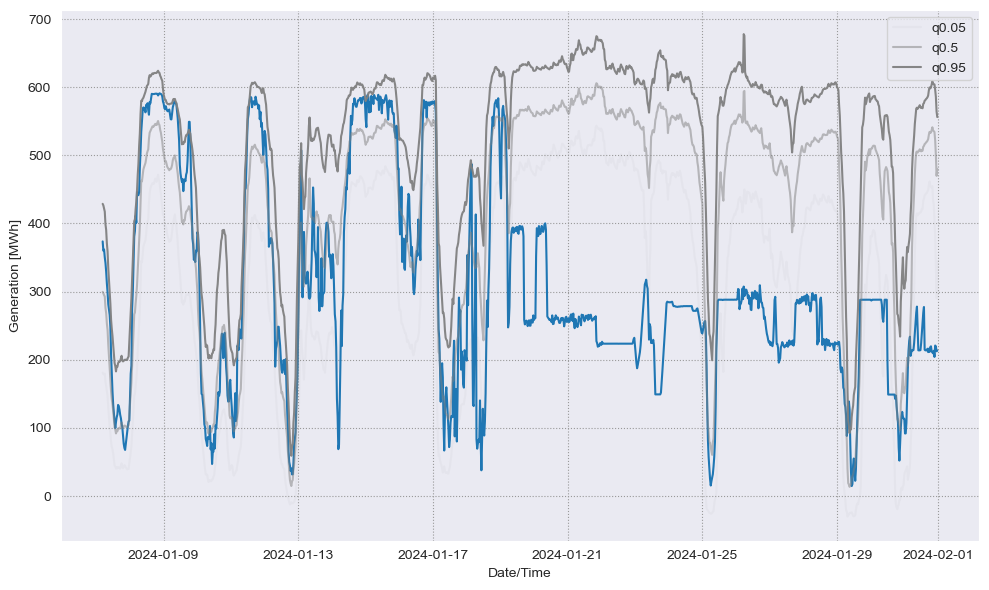

In [130]:
xgboost_model_wind.plot_quantils(feature_engineerer_wind.y_test, qr_wind_nn, quantiles)